In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [36]:
device = torch.device('mps')

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [5]:
train_df.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
id,188533.0,94266.000000,54424.933488,0.0,47133.0,94266.0,141399.0,188532.0
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


In [6]:
#missing
(train_df.isnull().sum().sort_values(ascending=False)*100)/len(train_df)

clean_title     11.360876
fuel_type        2.696080
accident         1.300568
id               0.000000
brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
price            0.000000
dtype: float64

In [7]:
(test_df.isnull().sum().sort_values(ascending=False)*100)/len(train_df)

clean_title     7.552524
fuel_type       1.794381
accident        0.865631
id              0.000000
brand           0.000000
model           0.000000
model_year      0.000000
milage          0.000000
engine          0.000000
transmission    0.000000
ext_col         0.000000
int_col         0.000000
dtype: float64

In [8]:
train_df.drop_duplicates(inplace=True)

In [9]:
test_df.drop_duplicates(inplace=True)

In [10]:
from ydata_profiling import ProfileReport
report = ProfileReport(train_df)
#report

In [11]:
train_df.drop('clean_title',axis=1,inplace=True)
test_df.drop('clean_title',axis=1,inplace=True)

In [12]:
train_df['fuel_type'].fillna('Gasoline',inplace=True)
test_df['fuel_type'].fillna('Gasoline',inplace=True)

In [13]:
train_df.groupby('accident')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
accident,,,,,,,,
At least 1 accident or damage reported,41567.0,25334.071475,47378.623057,2000.0,11000.0,18000.0,30000.0,2954083.0
None reported,144514.0,49024.804144,84593.013790,2000.0,20000.0,35000.0,54500.0,2954083.0


In [14]:
def fill_acc(cols):
    acc = cols[0]
    price = cols[1]
    if pd.isna(acc) == True:
        if price > 25334.071475:
            return "None reported"
        else:
            return "At least 1 accident or damage reported"
    else:
        return acc

In [15]:
train_df['accident'] = train_df[['accident','price']].apply(fill_acc,axis=1)

In [16]:
test_df['accident'].fillna("None reported",inplace=True)

In [17]:
(train_df.isnull().sum().sort_values(ascending=False)*100)/len(train_df)

id              0.0
brand           0.0
model           0.0
model_year      0.0
milage          0.0
fuel_type       0.0
engine          0.0
transmission    0.0
ext_col         0.0
int_col         0.0
accident        0.0
price           0.0
dtype: float64

In [18]:
(test_df.isnull().sum().sort_values(ascending=False)*100)/len(train_df)

id              0.0
brand           0.0
model           0.0
model_year      0.0
milage          0.0
fuel_type       0.0
engine          0.0
transmission    0.0
ext_col         0.0
int_col         0.0
accident        0.0
dtype: float64

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     188533 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      188533 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 17.3+ MB


<Figure size 400x500 with 0 Axes>

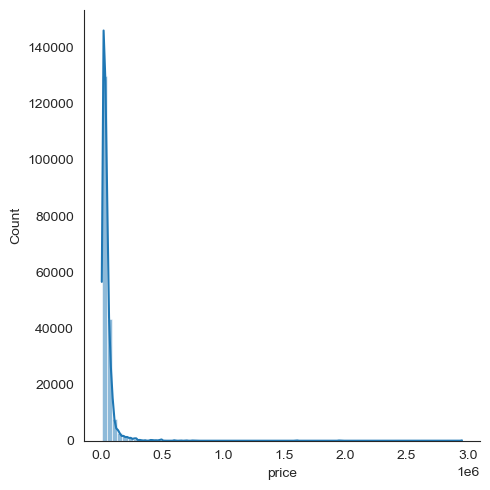

In [22]:
sns.set_style('white')
plt.figure(figsize=(4,5))
sns.displot(x='price',bins=70,data=train_df,kde=True)

In [29]:
cat_cols = ['brand', 'model','model_year','fuel_type','engine','transmission', 'ext_col', 'int_col', 'accident']
cont_cols = ['milage']
y_col = ['price']

In [47]:
for col in cat_cols:
    train_df[col] = train_df[col].cat.add_categories('unknown')
    test_df[col] = test_df[col].cat.set_categories(train_df[col].cat.categories)

In [48]:
cat_train = np.stack([train_df[col].cat.codes for col in cat_cols],axis=1)
cat_test = np.stack([test_df[col].cat.codes for col in cat_cols],axis=1)

In [49]:
cat_train = torch.LongTensor(cat_train).to(device)
cat_test = torch.LongTensor(cat_test).to(device)

In [50]:
cat_szs = [len(train_df[col].cat.categories) for col in cat_cols]

In [51]:
cat_szs_2 = [len(test_df[col].cat.categories) for col in cat_cols]

In [67]:
cat_test.shape

torch.Size([125690, 9])

In [56]:
cat_szs_2 == cat_szs

True

In [54]:
cat_train

tensor([[  31,  495,   16,  ...,  312,   71,    1],
        [  28,  930,   11,  ...,  263,   10,    0],
        [   9, 1575,   11,  ...,   38,   71,    1],
        ...,
        [  36,  223,   30,  ...,  304,   14,    1],
        [   3, 1471,   31,  ...,   82,   14,    1],
        [  43, 1028,   25,  ...,  304,   14,    1]], device='mps:0')

In [55]:
cat_test

tensor([[  26, 1390,   24,  ...,  304,   10,    1],
        [  26, 1377,   29,  ...,  263,   14,    1],
        [  14,  636,   31,  ...,  304,   57,    1],
        ...,
        [   3,  184,   21,  ...,   29,   14,    1],
        [   3, 1246,   21,  ...,   29,   14,    1],
        [   9, 1671,   27,  ...,  263,   14,    1]], device='mps:0')

In [57]:
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]

In [58]:
emb_szs

[(58, 29),
 (1898, 50),
 (35, 18),
 (8, 4),
 (1118, 50),
 (53, 27),
 (320, 50),
 (157, 50),
 (3, 2)]

In [59]:
cont_train = np.stack([train_df[col].values for col in cont_cols],axis=1)
cont_test = np.stack([test_df[col].values for col in cont_cols],axis=1)

In [61]:
cont_train = torch.Tensor(cont_train).to(device)
cont_test = torch.Tensor(cont_test).to(device)

In [64]:
cont_train.shape

torch.Size([188533, 1])

In [65]:
cont_test.shape

torch.Size([125690, 1])

In [71]:
y_train = torch.Tensor(train_df[y_col].values).to(device)

In [72]:
y_train

tensor([[ 4200.],
        [ 4999.],
        [13900.],
        ...,
        [86900.],
        [84900.],
        [28995.]], device='mps:0')

#### model

In [76]:
class Model(nn.Module):
    
    def __init__(self,emb_szs,n_cont,out_sz,layers,p=0.35):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout()
        n_emb = sum([nf for ni,nf in emb_szs])
        
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_in = n_emb + n_cont
        
        layerlist = []
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self,x_cat,x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        return x
        
        
    
    

In [99]:
model = Model(emb_szs,cont_train.shape[1],1,[1024,1024,512,256,128,64,32,16,8]).to(device)

In [100]:
model

Model(
  (embeds): ModuleList(
    (0): Embedding(58, 29)
    (1): Embedding(1898, 50)
    (2): Embedding(35, 18)
    (3): Embedding(8, 4)
    (4): Embedding(1118, 50)
    (5): Embedding(53, 27)
    (6): Embedding(320, 50)
    (7): Embedding(157, 50)
    (8): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=281, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.35, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(51

In [101]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)
num_epochs = 100

In [102]:
losses = []
for epoch in range(num_epochs):
    y_pred = model.forward(cat_train,cont_train)
    loss = torch.sqrt(criterion(y_pred,y_train))#RMSE
    losses.append(loss.item())
    print(f"epoch : {epoch+1}/{num_epochs} loss : {loss.item()} ")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch : 1/100 loss : 90209.53125 
epoch : 2/100 loss : 90209.5 
epoch : 3/100 loss : 90209.421875 
epoch : 4/100 loss : 90209.328125 
epoch : 5/100 loss : 90209.234375 
epoch : 6/100 loss : 90209.15625 
epoch : 7/100 loss : 90209.0859375 
epoch : 8/100 loss : 90209.0234375 
epoch : 9/100 loss : 90208.9609375 
epoch : 10/100 loss : 90208.90625 
epoch : 11/100 loss : 90208.8515625 
epoch : 12/100 loss : 90208.796875 
epoch : 13/100 loss : 90208.7265625 
epoch : 14/100 loss : 90208.6640625 
epoch : 15/100 loss : 90208.6015625 
epoch : 16/100 loss : 90208.53125 
epoch : 17/100 loss : 90208.4609375 
epoch : 18/100 loss : 90208.3984375 
epoch : 19/100 loss : 90208.328125 
epoch : 20/100 loss : 90208.2578125 
epoch : 21/100 loss : 90208.1796875 
epoch : 22/100 loss : 90208.109375 
epoch : 23/100 loss : 90208.0234375 
epoch : 24/100 loss : 90207.953125 
epoch : 25/100 loss : 90207.8671875 
epoch : 26/100 loss : 90207.78125 
epoch : 27/100 loss : 90207.6875 
epoch : 28/100 loss : 90207.59375 
e